In [1]:
import warnings
import numpy as np
import scipy.sparse as sp
from numpy import matrix
from numpy import linalg
from qutip import *
from qutip import spre, spost, sprepost, thermal_dm, mesolve, Options
from qutip import tensor, identity, destroy, sigmax, sigmaz, basis, qeye, dims
%pylab inline


Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shape', 'squeeze', 'info', 'identity']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
Del = 1.0    # The number of qubits in the system.
wq = 0.5     # Energy of the 2-level system.
Hsys = 0.5 * wq * sigmaz() + 0.5 * Del * sigmax()

In [3]:
Q = sigmaz()

In [4]:
wc = 0.05                # Cutoff frequency.
alpha = 2.5/np.pi        # Coupling strength.
N = 30                  # Number of cavity fock states.
Temperature = 1/0.95     # Tempertaure.
tlist = np.linspace(0, 40, 600)
initial_state = basis(2,1) * basis(2,1).dag()                # Initial state of the system.
return_vals = [0.5*(sigmaz()-qeye(2))]  # List for which to calculate expectation value 

print(return_vals)

dot_energy, dot_state = Hsys.eigenstates()
deltaE = dot_energy[1] - dot_energy[0]
print(deltaE)

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.  0.]
 [ 0. -1.]]]
1.118033988749895


In [6]:


dot_energy, dot_state = Hsys.eigenstates()
deltaE = dot_energy[1] - dot_energy[0]
if (Temperature < deltaE/2):
    warnings.warn("Given Temperature might not provide accurate results")
gamma = deltaE / (2 * np.pi * wc)
wa = 2 * np.pi * gamma * wc  # reaction coordinate frequency
g = np.sqrt(np.pi * wa * alpha / 2.0)  # reaction coordinate coupling
nb = (1 / (np.exp(wa/Temperature) - 1))

def nb_0(omega):
    return (1 / (np.exp(omega/Temperature) - 1))

# Reaction coordinate hamiltonian/operators

dimensions = dims(Q)
a = tensor(destroy(N), qeye(dimensions[1]))
unit = tensor(qeye(N), qeye(dimensions[1]))
Nmax = N * dimensions[1][0]
Q_exp = tensor(qeye(N), Q)
Hsys_exp = tensor(qeye(N), Hsys)
e_ops_exp = [tensor(qeye(N), kk) for kk in return_vals]

na = a.dag() * a
xa = a.dag() + a

# decoupled Hamiltonian
H0 = wa * a.dag() * a + Hsys_exp
# interaction
H1 = (g * (a.dag() + a) * Q_exp)
H = H0 + H1


gamma1=gamma*wa*(1+nb_0(wa))
gamma1_bar=gamma*wa*(nb_0(wa))

print(gamma1, gamma1_bar)
#gamma1= 3.78385
#gamma1_bar= 3.19535
#L1=tensor(b, identity(2)  )
#L2=tensor(b.dag(), identity(2)   )
L=[np.sqrt(gamma1) * a, np.sqrt(gamma1_bar)*a.dag() ]

rho0 = (tensor(thermal_dm(N, nb), initial_state))
output_RC = mesolve(H, rho0, tlist, L, e_ops_exp)


all_energy, all_state = H.eigenstates()

6.081280985140722 2.102407407843339


In [7]:
options = Options(nsteps=15000, store_states=True)        # Options for the solver.

output = rcsolve(Hsys, initial_state, tlist, return_vals, Q, wc, alpha, N, 
                Temperature, options=options)

In [77]:
from qutip.nonmarkov.heom import HSolverDL

# Bath description parameters (for HEOM)
temperature = 1.0/0.95 # in units where Boltzmann factor is 1
Nk = 2 # number of exponentials in approximation of the the spectral density
Ncut = 30 # cut off parameter for the bath

eps = 0.5     # Energy of the 2-level system.
Del = 1.0    # Tunnelling term
Hsys = 0.5*eps*sigmaz() + 0.5*Del* sigmax()

# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz() # coupling operator
gam = 0.05 # cut off frequency
lam = 2.5/np.pi # coupling strenght

# Configure the solver
hsolver = HSolverDL(Hsys, Q, lam, temperature, Ncut, Nk, gam, stats=True)

# Initial state of the system.
rho0 = initial_state* initial_state.dag()   
# Times to record state
tlist = np.linspace(0, 40, 600)
# run the solver
result = hsolver.run(rho0, tlist)
hsolver.stats.report()

# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11exp = expect(result.states, return_vals)


Hierarchy Solver Stats

config
------
### Timings:
 - 0:00:00.309658 (97.30% section, 21.05% total)	hierarchy contruct
 - 0:00:00.000473 (0.15% section, 0.03% total)	Liouvillian contruct
 - 0:00:00.318241	config total time
### Counts:
 - 496	Num hierarchy elements
 - 1860	Num he interactions
### Messages:
 - options:	renormalisation;boundary cutoff approx

run
---
### Timings:
 - 0:00:00.000141 (0.01% section, 0.01% total)	initialize
 - 0:00:01.152323 (99.99% section, 78.35% total)	integrate
 - 0:00:01.152476	run total time
### Counts:
### Messages:

Summary
-------
0:00:01.470718	 solver total time


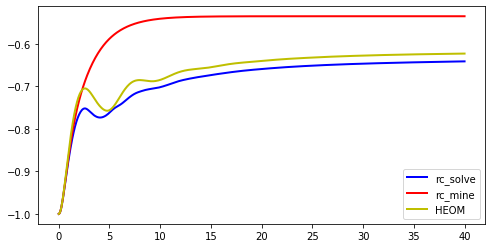

In [78]:
fig, axes = subplots(1, 1, sharex=True, figsize=(8,4))
axes.plot(tlist, real(output.expect[0]), 'b', linewidth=2, label="rc_solve")
axes.plot(tlist, real(output_RC.expect[0]), 'r', linewidth=2, label="rc_mine")
axes.plot(tlist, np.real(P11exp), 'y', linewidth=2, label="HEOM")


axes.legend(loc=0)